## Build and Train Pneumonia Detection Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from skimage.io import imread, imshow
from itertools import chain
import sklearn.model_selection as skl
from random import sample 

## Process metadata for easier model training:
- Add full path column to read images
- Add columns per disease
- Add 'pneumonia_class' binary output column indicating presence of Pneumonia

In [2]:
# Add full path column to read images

## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index       Finding Labels  Follow-up #  Patient ID  \
105634  00028421_003.png  Nodule|Pneumothorax            3       28421   
103936  00027726_034.png         Infiltration           34       27726   
23652   00006263_000.png           No Finding            0        6263   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
105634           60              M            PA                 3056   
103936           58              M            AP                 3056   
23652            47              F            PA                 2021   

        Height]  OriginalImagePixelSpacing[x        y]  Unnamed: 11  \
105634     2544                     0.139000  0.139000          NaN   
103936     2544                     0.139000  0.139000          NaN   
23652      2021                     0.194311  0.194311          NaN   

                                            path  
105634  /data/images_012/images/00028421_003.png  
103936  /data/images_011/images/00027726_034.png  
23652   /data/images_003/images/00006263_000.png

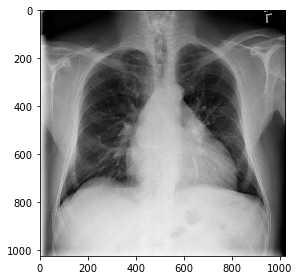

In [3]:
# Inspect a sample xray image
imshow(all_xray_df.path[0])

In [4]:
# Add columns per disease

## Here we create some extra columns with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis Hernia  Infiltration  \
0                        0.143  ...        0.0       0.0    0.0           0.0   
1                        0.143  ...        1.0       0.0    0.0           0.0   
2                        0.168  ...        0.0       0.0    0.0           0.0   
3                        0.171  ...        0.0       0.0    0.0           0.0   
4                        0.143  ...        0.0       0.0    1.0           0.0   

   Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0   0.0         0.0     0.0                 0.0        0.0           0.0  
1   0.0         0.0     0.0                 0.0        0.0           0.0  
2   0.0         0.0     0.0                 0.0        0.0           0.0  
3   0.0         1.0     0.0                 0.0        0.0           0.0  
4   0.0         0.0     0.0                 0.0        0.0           0.0  

[5 rows x 28 columns]

Num Pneumonia:  1431


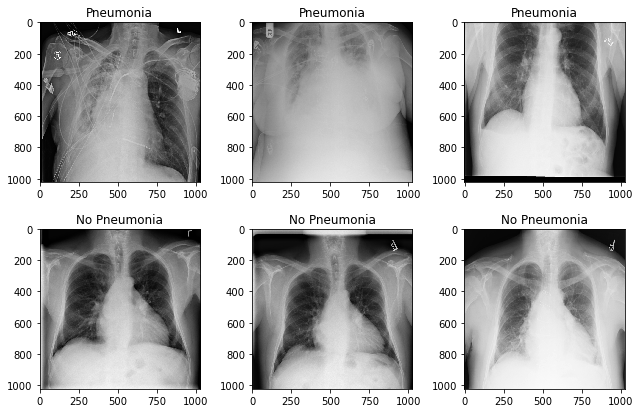

In [5]:
# Add 'pneumonia_class' binary output column indicating presence of Pneumonia

## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = np.where(all_xray_df['Finding Labels'].str.contains('Pneumonia'), 1, 0)
print("Num Pneumonia: ", all_xray_df['pneumonia_class'].sum())

plt.figure(figsize=(9,6))
plt.subplot(2,3,1); imshow(all_xray_df[all_xray_df['pneumonia_class'] == True].iloc[0].path); plt.title('Pneumonia')
plt.subplot(2,3,2); imshow(all_xray_df[all_xray_df['pneumonia_class'] == True].iloc[1].path); plt.title('Pneumonia')
plt.subplot(2,3,3); imshow(all_xray_df[all_xray_df['pneumonia_class'] == True].iloc[2].path); plt.title('Pneumonia')
plt.subplot(2,3,4); imshow(all_xray_df[all_xray_df['pneumonia_class'] == False].iloc[0].path); plt.title('No Pneumonia')
plt.subplot(2,3,5); imshow(all_xray_df[all_xray_df['pneumonia_class'] == False].iloc[1].path); plt.title('No Pneumonia')
plt.subplot(2,3,6); imshow(all_xray_df[all_xray_df['pneumonia_class'] == False].iloc[2].path); plt.title('No Pneumonia')
# plt.tight_layout()
plt.show()

## Create training and testing data:

In [6]:
def create_splits(all_xray_df_in):
    
    total_num_with_pneumonia = all_xray_df_in[all_xray_df_in['Finding Labels'].str.contains('Pneumonia')].shape[0]
    print("Total with Pneumonia: ", total_num_with_pneumonia)
    
    print("Split and stratify by Pneumonia:")
    train_df, valid_df = skl.train_test_split(all_xray_df_in, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df_in['Pneumonia'])
    print(f"Initial Train % Pneumonia: {train_df['Pneumonia'].sum()/len(train_df)}")
    print(f"Initial Valid % Pneumonia: {valid_df['Pneumonia'].sum()/len(valid_df)}\n")
    
    # In test dataset, we want equal representation of cases with and without Pneumonia
    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia==0].index.tolist()
    np_sample = sample(np_inds, len(p_inds)) # Equal number of indices w/ and w/o pneumonia
    train_df = train_df.loc[p_inds + np_sample]
    print(f"Equal Representative Pneumonia % in train_df: {train_df['Pneumonia'].sum()/len(train_df)}")
    print(f"Num Pneumonia in train_df: {train_df['Pneumonia'].sum()}")
    print(f"train_df.shape: {train_df.shape}\n")
    
    # Include 20% positive cases in validation set
    # We assume that the rate of pneumonia is higher in clinical setting where scan is required
    p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

    # Pull a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample
    np_sample = sample(np_inds,4*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    print(f"Clinically Representative Pneumonia % in valid_df: {valid_df['Pneumonia'].sum()/len(valid_df)}")
    print(f"Num Pneumonia in valid_df: {valid_df['Pneumonia'].sum()}")
    print(f"valid_df.shape: {valid_df.shape}\n")
    
    if (train_df['Pneumonia'].sum() + valid_df['Pneumonia'].sum() == total_num_with_pneumonia):
        print("All samples cases with Pneumonia are included within Train and Validation sets.")
    
    return train_df, valid_df

In [7]:
train_df, valid_df = create_splits(all_xray_df)

Total with Pneumonia:  1431
Split and stratify by Pneumonia:
Initial Train % Pneumonia: 0.012765340706386016
Initial Valid % Pneumonia: 0.012754191937210132

Equal Representative Pneumonia % in train_df: 0.5
Num Pneumonia in train_df: 1145.0
train_df.shape: (2290, 29)

Clinically Representative Pneumonia % in valid_df: 0.2
Num Pneumonia in valid_df: 286.0
valid_df.shape: (1430, 29)

All samples cases with Pneumonia are included within Train and Validation sets.


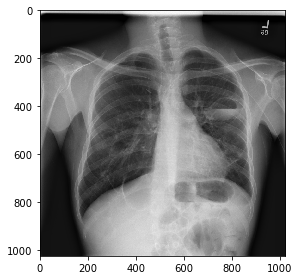

In [8]:
imshow(train_df.sample(3).iloc[0].path)

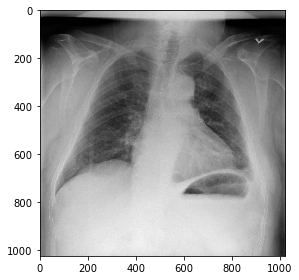

In [9]:
imshow(valid_df.sample(3).iloc[0].path)

In [10]:
train_df['pneumonia_class'] = train_df['pneumonia_class'].astype(str)
valid_df['pneumonia_class'] = valid_df['pneumonia_class'].astype(str)

# Model Definition & Training

We will use ResNet50 as our model backbone for transfer learning and fine tuning.
Both training and validation images must use ResNet style preprocessing.
Training images will undergo additional image augmentation.

In [11]:
# Training Imports
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential, Model
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input as preprocess_input_VGG
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as preprocess_input_ResNet
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


#### Image Augmentation

In [12]:
IMG_SIZE = (224, 224)

train_idg = ImageDataGenerator(preprocessing_function=preprocess_input_ResNet,
#                               rescale=1. / 255.0, # We use the ResNet preprocessing function
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 32, # Was 9 for some reason?
                                          shuffle = True
                                         )

# Note that the validation data should not be augmented! We only want to match ResNet image preprocessing
val_idg = ImageDataGenerator(preprocessing_function=preprocess_input_ResNet # 
                            # rescale=1. / 255.0
                            )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32,
                                         shuffle = True) ## upped from 6

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [13]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

AUGMENTED Test Set


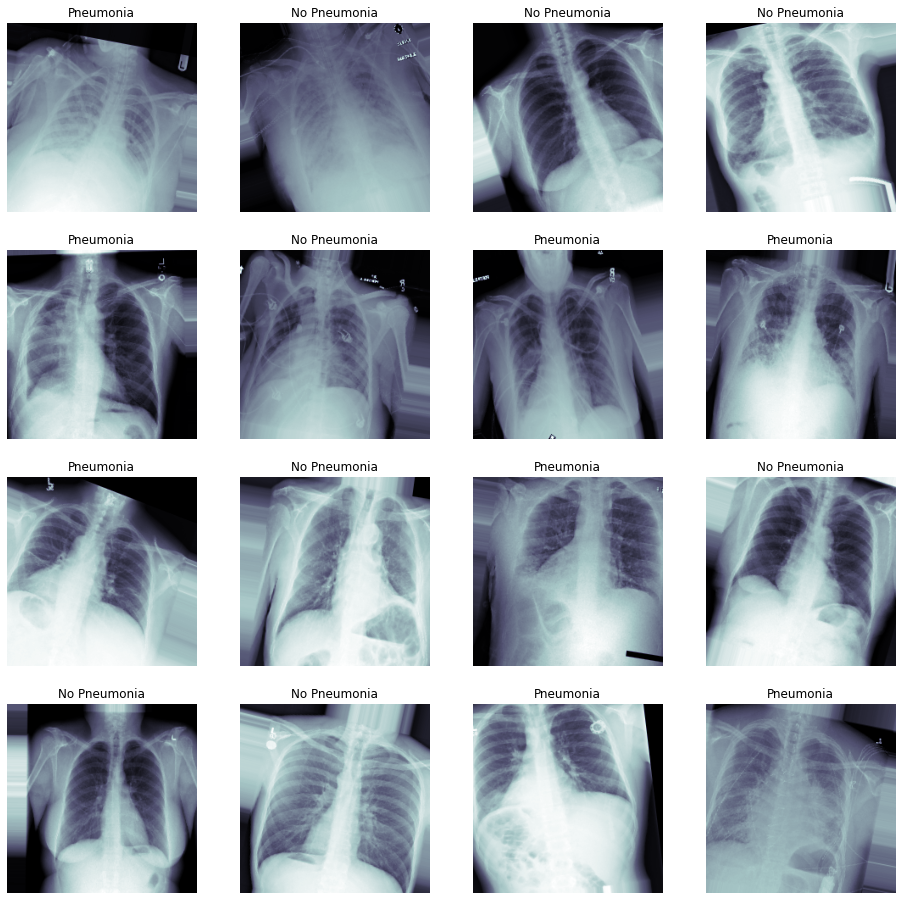

In [14]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

print("AUGMENTED Test Set")

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

NOT augmented Validation Set


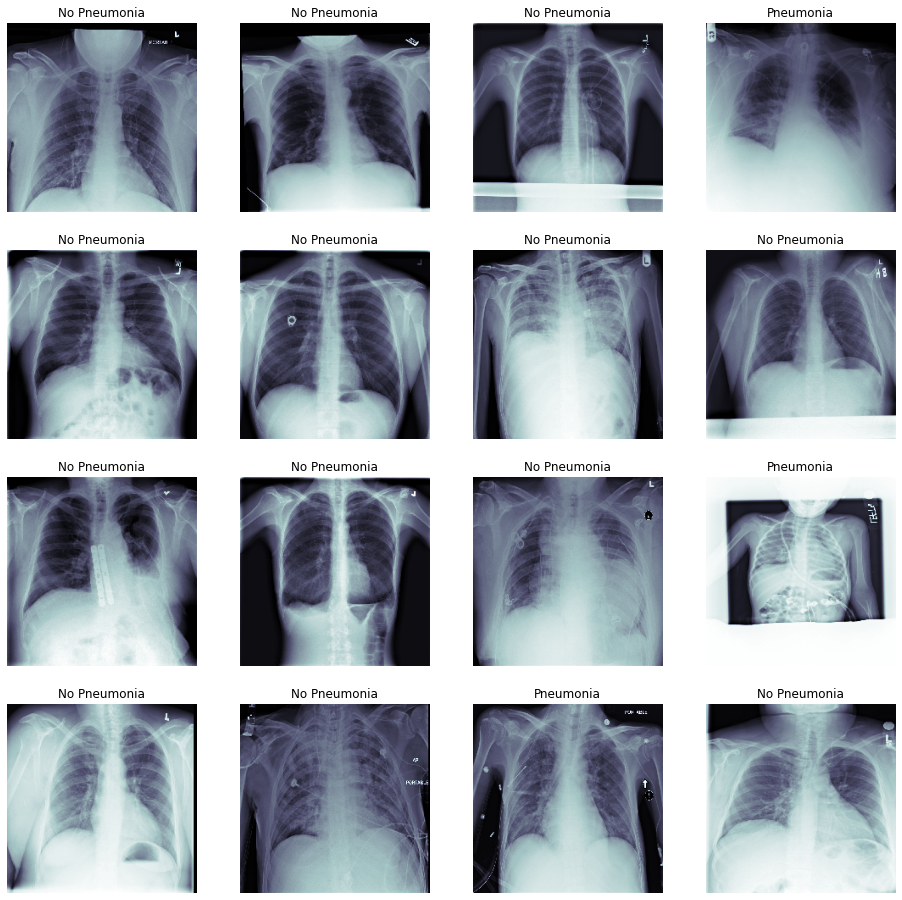

In [15]:
print("NOT augmented Validation Set")

v_x, v_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(v_x, v_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

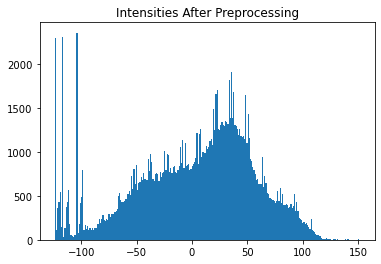

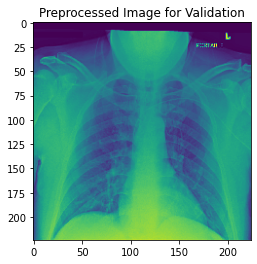

In [16]:
# NOTE: ResNet image preprocessing in TF.Keras uses "caffe" preprocessing style, which is centered but not normalized
# We verify during inference that we use the same type of preprocessing
plt.hist(v_x[0].ravel(), bins=256)
plt.title("Intensities After Preprocessing")
plt.show()

plt.imshow(v_x[0,:,:,0]) #  , cmap = 'bone')
plt.title('Preprocessed Image for Validation')
plt.show()

## Build your model: 

We will use ResNet50 as our model backbone for transfer learning and fine tuning.

Load ResNet 50 as base model:

In [17]:
resnet_model_in = ResNet50(include_top=True, weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [18]:
resnet_model_in.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Freeze all layers except last convolutional layer:

In [19]:
transfer_layer = resnet_model_in.get_layer('conv5_block3_out')
resnet_model = Model(inputs=resnet_model_in.input,
                   outputs=transfer_layer.output)
for layer in resnet_model.layers[:-4]:
    layer.trainable = False
for layer in resnet_model.layers[-4:]:
    print(layer)
    layer.trainable = True
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [20]:
new_model = Sequential()

# Add the convolutional part of the ResNet model from above.
# new_model.add(vgg_model)
new_model.add(resnet_model)

# Flatten the output of the ResNet model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the ResNet model has
# recognized in the image.
# new_model.add(Dense(1024, use_bias=False, kernel_initializer='he_uniform'))
# new_model.add(BatchNormalization())
# new_model.add(Activation("relu"))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
# new_model.add(Dropout(0.2))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the ResNet model has
# recognized in the image.
# new_model.add(Dense(512, use_bias=False, kernel_initializer='he_uniform'))
# new_model.add(BatchNormalization())
# new_model.add(Activation("relu"))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.25))


# Add a dense (aka. fully-connected) layer.
# This is for combining features that the ResNet model has
# recognized in the image.
# new_model.add(Dense(256, use_bias=False, kernel_initializer='he_uniform'))
new_model.add(Dense(64, use_bias=False, kernel_initializer='he_uniform'))
new_model.add(BatchNormalization())
new_model.add(Activation("relu"))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6422528   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)               

In [21]:
## Save model architecture to a .json:

model_json = new_model.to_json()
with open("Pneumonia_Detection_Model.json", "w") as json_file:
    json_file.write(model_json)

In [22]:
## Add checkpoints to save model.
## This will save the 'best' version of your model by comparing it to previous epochs of training.

## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Monitor validation loss to verify that the model is learning.

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', # Performance metric
                             verbose=1, 
                             save_best_only=True, 
                             mode = 'min', # Minimize metric
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss',
                      mode= 'min',
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [23]:
## train the model

optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [24]:
history = new_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 20, 
                          callbacks = callbacks_list)

# ## Run for 5 epochs to see if any learning occurs:
# history = new_model.fit_generator(train_gen, 
#                                   validation_data = (valX, valY), 
#                                   epochs = 5)

Epoch 1/20
72/72 [==============================] - 67s 936ms/step - loss: 0.8762 - binary_accuracy: 0.5620 - val_loss: 0.8748 - val_binary_accuracy: 0.4375

Epoch 00001: val_loss improved from inf to 0.87480, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
72/72 [==============================] - 58s 810ms/step - loss: 0.7945 - binary_accuracy: 0.5856 - val_loss: 0.7720 - val_binary_accuracy: 0.6875

Epoch 00002: val_loss improved from 0.87480 to 0.77196, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
72/72 [==============================] - 60s 838ms/step - loss: 0.7175 - binary_accuracy: 0.6166 - val_loss: 0.7475 - val_binary_accuracy: 0.5938

Epoch 00003: val_loss improved from 0.77196 to 0.74746, saving model to xray_class_my_model.best.hdf5
Epoch 4/20
72/72 [==============================] - 60s 835ms/step - loss: 0.6726 - binary_accuracy: 0.6437 - val_loss: 0.7807 - val_binary_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.74746
Epoch 5/20
72/7

##### After training for some time, inspect model performance by plotting some performance statistics:

In [25]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

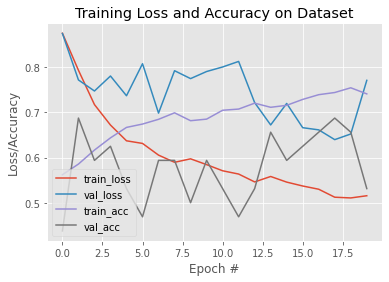

In [26]:
plot_history(history)

We see validation loss decreases over time, so the model is learning even though the validation loss curve fluctuates. Training accuracy increases with a peak near 0.75.

In [27]:
# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    print(f"Loading model at path '{model_path}' with weights at path '{weight_path}'")
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights(weight_path)
    
    optimizer = 'adam' # Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [30]:
# Load the saved model:

loaded_model = load_model("Pneumonia_Detection_Model.json", "xray_class_my_model.best.hdf5")

Loading model at path 'Pneumonia_Detection_Model.json' with weights at path 'xray_class_my_model.best.hdf5'


In [61]:
valX, valY = val_gen.next()
pred_Y = loaded_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 0s 8ms/sample


In [62]:
## After training, make some predictions to assess the model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, so we do not attempt to make the model perfect.

# Use if not loading a model above:
# new_model.load_weights(weight_path)
# pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [69]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

# function to plot the roc_curve.
def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
# function to plot the precision_recall_curve.
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

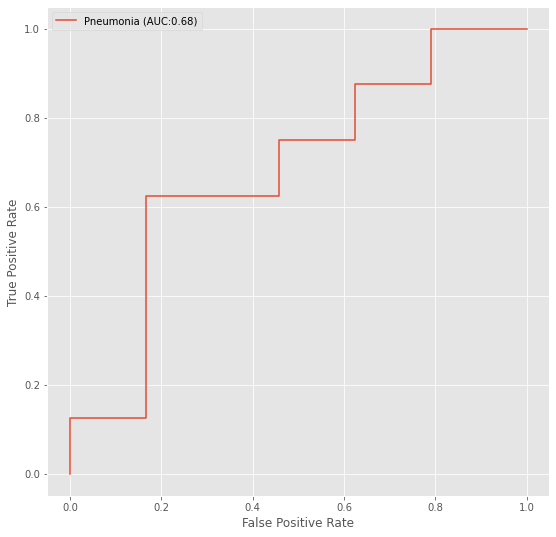

In [70]:
plot_roc_curve(valY, pred_Y)

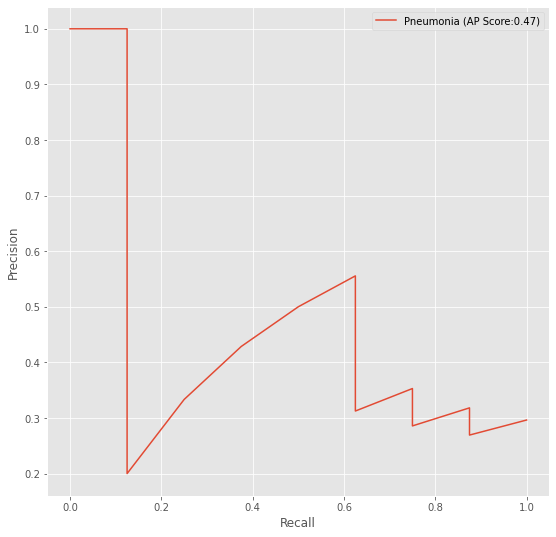

In [71]:
plot_precision_recall_curve(valY, pred_Y)

## Optimize Model Performance

Determine the proper classification threshold that optimizes the model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

I want to optimize my model's performance for **recall**, so that the model has a fewer number of false negatives.
All readings, false positives and false negatives, must be reviewed by a radiologist.
- **False Positives** incorrectly indicate the presence of Pneumonia. Further review by a radiologist my waste time and resources for the patient and hospital, but a final diagnosis is confirmed by the radiologist and there is no life-threatening Pneumonia that has gone undetected in the patient.
- **False Negatives** incorrectly indicate no presence of Peneumonia. This is a life-threatening scenario for the patient and it is vital that a radiologist review the result and make a final diagnosis incorporating their own expert analysis. False negative occurances are severe failures of the algorithm, so the algorithm has been trained to attempt to minimize false negative readings.

Below I plot F1 score vs threshold to find an optimal threshold for my model's performance:

Best threshold: 0.42
Precision: 0.5555555555555556
Recall: 0.625
Max F1 Score: 0.5882352941176471


Text(0, 0.5, 'F1 Score')

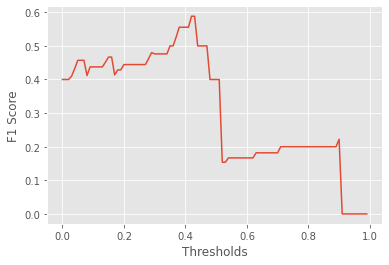

In [72]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

from sklearn.metrics import recall_score, precision_score, f1_score

# Determine optimal theshold

best_threshold, max_f1 = 0, 0
thresholds_list = np.arange(0, 1, 0.01).tolist()
f1_list = np.zeros_like(thresholds_list).tolist()

for i in range(len(thresholds_list)):
    curr_threshold = thresholds_list[i]
    
    # Calculate F1 Score for this threshold
    curr_f1 = f1_score(valY, pred_Y > curr_threshold, labels=np.unique(pred_Y > curr_threshold))
    
    # If better f1 score is found, update best threshold
    if curr_f1 > max_f1:
        best_threshold = curr_threshold
        max_f1 = curr_f1
    
    if not np.isnan(curr_f1):
        f1_list[i] = curr_f1
    
print(f"Best threshold: {best_threshold}")
print(f"Precision: {precision_score(valY, pred_Y > best_threshold)}")
print(f"Recall: {recall_score(valY, pred_Y > best_threshold)}")
print(f"Max F1 Score: {max_f1}")

plt.plot(thresholds_list, f1_list)
plt.xlabel("Thresholds")
plt.ylabel("F1 Score")
plt.show()

We choose a classification threshold of **0.42**, because F1 score is maximized with a value of 0.588, Recall is favored with a value of 0.625, and Precision maintains a value of 0.56.

Recall score: 0.625


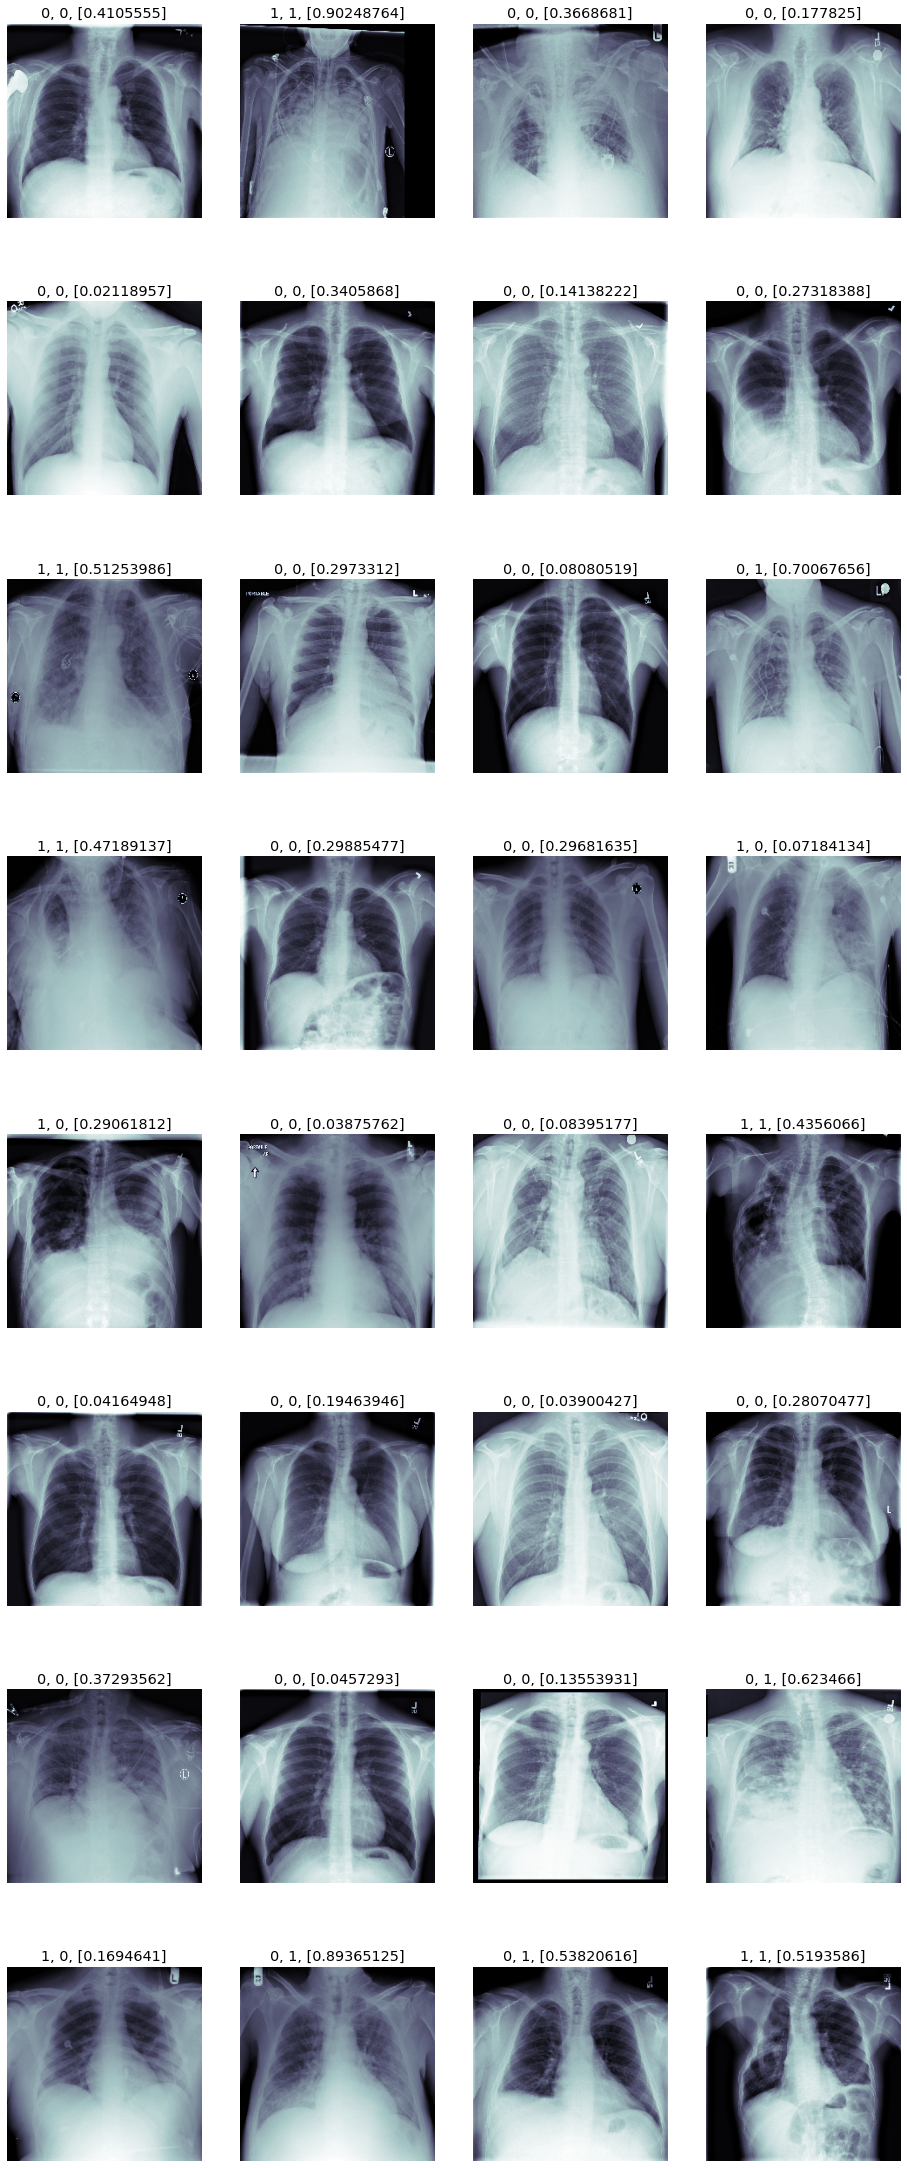

In [74]:
## Let's look at some examples of true vs. predicted with our best model: 

batchsize = 32

YOUR_THRESHOLD = 0.42
print(f"Recall score: {recall_score(valY, pred_Y > YOUR_THRESHOLD )}")

fig, m_axs = plt.subplots(8, 4, figsize = (16, 40))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:batchsize], valY[0:batchsize], m_axs.flatten()): # was testY?
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title(f"1, 1, {pred_Y[i]}")
        else:
            c_ax.set_title(f'1, 0, {pred_Y[i]}')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title(f'0, 1, {pred_Y[i]}')
        else:
            c_ax.set_title(f'0, 0, {pred_Y[i]}')
    c_ax.axis('off')
    i=i+1